### Importing needed packages

In [119]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss

### Setting up parameters

In [174]:
#input parameters
S_0 = 100                                   #asset price at t=0
K = 10                                      #Strike price
optionType = "CALL"                         #Call or put option; "CALL" for call option, "PUT" for put option
optionKind = "EUR"                          #American or European option; "EUR" or "US"
Bermudan = "OFF"                            #Bermudan option ON or OFF
r = .06                                     #yearly interest rate
T = 1                                       #total period in years
steps = 50                                  #amount of steps                            #step duration
vol = 0.01                                   #volatility
q=0                                         #dividend yield


### Script to calculate European/American call/put option prices

In [177]:
#calculating step-by-step option value
def calculateOptionValue (fu, fd, u, d, dt):
    p = (math.exp(r*dt) - d) / (u - d)
    fvalue = (p*fu + (1-p)*fd) * math.exp(-r*dt)
    return fvalue

#main function
def optionValuation (S_0, K, steps, optionKind, optionType, vol):
    
    """Determining the Option value using a binomial tree"""
    
    dt = T / steps  
    #calculating volatility
    u = math.exp(vol * math.sqrt(dt))           #upward volatility
    d = math.exp(-(vol * math.sqrt(dt)))        #downward volatility

    #generate table with all associated asset prices
    table = []
    for i in range(0, steps+1):
        table.append([])
        for j in range(0, i+1):
            table[i].append(S_0 * (u ** (i-j)) * (d ** j) )
    table.reverse()

    #generate table with all associated option prices
    table_prices = []
    for i in range(len(table)):
        table_prices.append([])
        if i == 0:
            for j in range(len(table[i])):
                if optionType == "CALL":
                    table_prices[i].append(max(table[i][j]-K,0))
                elif optionType == "PUT":
                    table_prices[i].append(max(K-table[i][j],0))
        else:
            for j in range(len(table[i])):
                if optionKind == "EUR":
                    optionValue = calculateOptionValue(table_prices[i-1][j], table_prices[i-1][j+1], u, d, dt)
                    if Bermudan == "OFF":
                        table_prices[i].append(optionValue)
                    elif Bermudan == "ON":
                        if j == int(steps/2) or j == int(steps/4) or j == int(3*steps/4):
                            if optionType == "CALL":
                                payOff = table[i][j] - K
                                if payOff > optionValue:
                                    table_prices[i].append(payOff)
                                else:
                                    table_prices[i].append(optionValue)
                            elif optionType == "PUT":
                                payOff =  K - table[i][j]
                                if payOff > optionValue:
                                    table_prices[i].append(payOff)
                                else:
                                    table_prices[i].append(optionValue)
                        else:
                            table_prices[i].append(optionValue)
                        
                elif optionKind == "US":
                    if optionType == "CALL":
                        optionValue = calculateOptionValue (table_prices[i-1][j], table_prices[i-1][j+1], u, d, dt)
                        payOff = table[i][j] - K
                        if payOff > optionValue:
                            table_prices[i].append(payOff)
                        else:
                            table_prices[i].append(optionValue)
                    elif optionType == "PUT":
                        optionValue = calculateOptionValue (table_prices[i-1][j], table_prices[i-1][j+1], u, d, dt)
                        payOff =  K - table[i][j]
                        if payOff > optionValue:
                            table_prices[i].append(payOff)
                        else:
                            table_prices[i].append(optionValue)
                        
    return table_prices[-1][0]

optionValuation(S_0, K, steps, optionKind, optionType, 0.01)

90.58235466415736

### **Black Scholes vs Binomial tree**

In [112]:
#Black and Scholes
def d1(S_0, K, r, sigma, T):
    return (np.log(S_0/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S_0, K, r, sigma, T):
    return (np.log(S_0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 
def blackScholes(optionType,S_0, K, r, sigma, T):
    if optionType=="CALL":
        return S_0 * ss.norm.cdf(d1(S_0, K, r, sigma, T)) - K * np.exp(-r * T) * ss.norm.cdf(d2(S_0, K, r, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(S_0, K, r, sigma, T)) - S_0 * ss.norm.cdf(-d1(S_0, K, r, sigma, T))

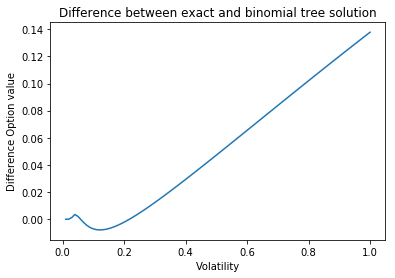

In [142]:
def onepointone(start,end,step):
    vary_vol = []
    ana_sols = []
    sigmas = []
    for sigma in np.linspace(start,end,step):
        sigmas.append(sigma)
        ana_sol = blackScholes(optionType,S_0, K, r, sigma, T)
        num_sol = optionValuation(S_0, K, steps, optionKind, optionType, sigma)
        vary_vol.append(ana_sol - num_sol)
        ana_sols.append(ana_sol)
    plt.plot(sigmas,vary_vol)
    plt.xlabel('Volatility')
    plt.ylabel('Difference Option value')
    plt.title('Difference between exact and binomial tree solution')
    plt.show()
    #plt.plot(ana_sols)


    
    
onepointone(0.01,1,100)


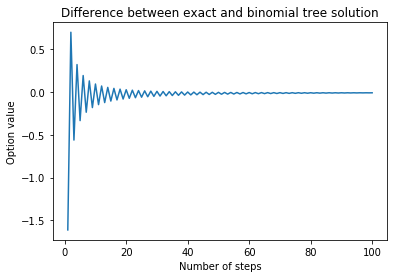

In [140]:
def onepointtwo(start, end, step):
    vary_dt = []
    for steps in np.linspace(start, end, step):
        ana_sol = blackScholes(optionType,S_0, K, r, vol, T)
        num_sol = optionValuation(S_0, K, int(steps), optionKind, optionType, vol)
        vary_dt.append(ana_sol - num_sol)
    plt.xlabel("Number of steps")
    plt.ylabel("Option value")
    plt.title("Difference between exact and binomial tree solution")
    plt.plot(np.linspace(start, end, step), vary_dt)
    
    
onepointtwo(1, 100, 100)
        
    

### **Trinomial tree**

In [97]:
def calculateTriOptionValue(fu, fm, fd, u, m, d, dt, vol):
    a=math.exp(r*dt/2)
    b=math.exp(-vol*math.sqrt(dt/2))
    c=math.exp(vol*math.sqrt(dt/2))
    p_u = ((a-b)/(c-b))**2 
    p_d = ((c-a)/(c-b))**2
    p_m = 1 - p_u - p_d
    fvalue = (p_u*fu + p_d*fd + p_m*fm) * math.exp(-r*dt)
    return fvalue


def TriOptionValuation (S_0, K, steps, optionKind, optionType, vol):
    
    """Determining the Option value using a trinomial tree"""
    
    dt = T / steps                          #Note: dt<(2*(vol**2))/(r-q)**2 has to be satisfied
    #calculating volatility
    u = math.exp(vol * math.sqrt(2*dt))           #upward volatility
    d = math.exp(-vol * math.sqrt(2*dt))          #downward volatility
    m = 1                               #middle volatility
                    
    #generate table with all associated asset prices
    table = []
    for i in range(0, steps+1):
        table.append([])
        for j in range(0, i):
            table[i].append(S_0 * (u ** (i-j)) * (m ** j) )
    for k in range(0,steps+1):
        for l in range(0,k+1):
            table[k].append(S_0 * (m ** (k-l)) * (d ** l))
    table.reverse()
    #print(table[0])

    #generate table with all associated option prices
    table_prices = []
    for i in range(len(table)):
        table_prices.append([])
        if i == 0:
            for j in range(len(table[i])):
                if optionType == "CALL":
                    table_prices[i].append(max(table[i][j]-K,0))
                elif optionType == "PUT":
                    table_prices[i].append(max(K-table[i][j],0))
        else:
            for j in range(len(table[i])):
                if optionKind == "EUR":
                    table_prices[i].append(calculateTriOptionValue(table_prices[i-1][j], table_prices[i-1][j+1],table_prices[i-1][j+2], u, m, d, dt,vol))
                elif optionKind == "US":
                    if optionType == "CALL":
                        optionValue = calculateTriOptionValue(table_prices[i-1][j], table_prices[i-1][j+1],table_prices[i-1][j+2], u, m, d, dt,vol)
                        payOff = table[i][j] - K
                        if payOff > optionValue:
                            table_prices[i].append(payOff)
                        else:
                            table_prices[i].append(optionValue)
                    elif optionType == "PUT":
                        optionValue = calculateTriOptionValue (table_prices[i-1][j], table_prices[i-1][j+1],table_prices[i-1][j+2], u, m, d, dt,vol)
                        payOff =  K - table[i][j]
                        if payOff > optionValue:
                            table_prices[i].append(payOff)
                        else:
                            table_prices[i].append(optionValue)

                        
    return table_prices[-1][0]

TriOptionValuation(S_0, K, steps, optionKind, optionType, 0.4)

18.92337855113071

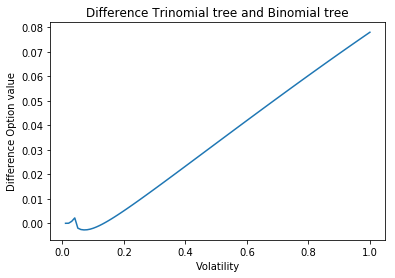

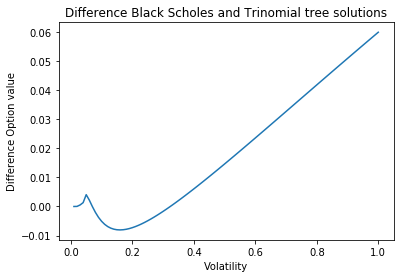

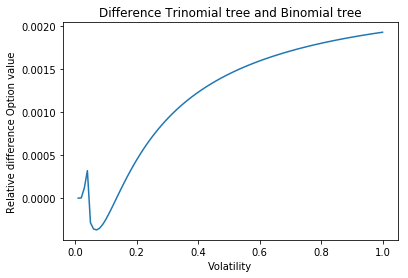

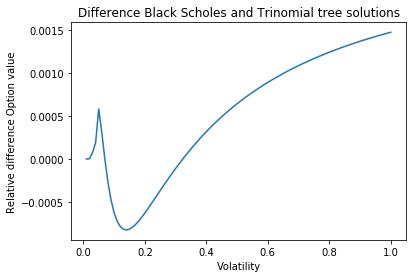

In [138]:
def triVSbi(start,end,step):
    diff = []
    sigmas = []
    for sigma in np.linspace(start,end,step):
        sigmas.append(sigma)
        bi_sol = optionValuation(S_0, K, steps, optionKind, optionType, sigma)
        tri_sol = TriOptionValuation(S_0, K, steps, optionKind, optionType, sigma)
        diff.append(tri_sol - bi_sol)
    plt.plot(sigmas, diff)
    plt.xlabel('Volatility')
    plt.ylabel('Difference Option value')
    plt.title('Difference Trinomial tree and Binomial tree')
    plt.show()
    
def triVSbs(start,end,step):
    diff = []
    sigmas = []
    for sigma in np.linspace(start,end,step):
        sigmas.append(sigma)
        bs_sol = blackScholes(optionType,S_0, K, r, sigma, T)
        tri_sol = TriOptionValuation(S_0, K, steps, optionKind, optionType, sigma)
        diff.append(bs_sol - tri_sol)
    plt.plot(sigmas, diff)
    plt.xlabel('Volatility')
    plt.ylabel('Difference Option value')
    plt.title('Difference Black Scholes and Trinomial tree solutions')
    plt.show() 
    
def triVSbiPerc(start,end,step):
    diff = []
    sigmas = []
    for sigma in np.linspace(start,end,step):
        sigmas.append(sigma)
        bi_sol = optionValuation(S_0, K, steps, optionKind, optionType, sigma)
        tri_sol = TriOptionValuation(S_0, K, steps, optionKind, optionType, sigma)
        diff.append((tri_sol - bi_sol)/tri_sol)
    plt.plot(sigmas, diff)
    plt.xlabel('Volatility')
    plt.ylabel('Relative difference Option value')
    plt.title('Difference Trinomial tree and Binomial tree')
    plt.show()
    
def triVSbsPerc(start,end,step):
    diff = []
    sigmas = []
    for sigma in np.linspace(start,end,step):
        sigmas.append(sigma)
        bs_sol = blackScholes(optionType,S_0, K, r, sigma, T)
        tri_sol = TriOptionValuation(S_0, K, steps, optionKind, optionType, sigma)
        diff.append((bs_sol - tri_sol)/bs_sol)
    plt.plot(sigmas, diff)
    plt.xlabel('Volatility')
    plt.ylabel('Relative difference Option value')
    plt.title('Difference Black Scholes and Trinomial tree solutions')
    plt.show()
    
triVSbi(0.01,1,100)
triVSbs(0.01,1,100)
triVSbiPerc(0.01,1,100)
triVSbsPerc(0.01,1,100)



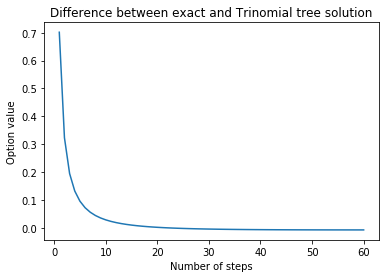

In [143]:
def onepointtwo2(start, end, step):
    vary_dt = []
    for steps in np.linspace(start, end, step):
        ana_sol = blackScholes(optionType,S_0, K, r, vol, T)
        num_sol = TriOptionValuation(S_0, K, int(steps), optionKind, optionType, vol)
        vary_dt.append(ana_sol - num_sol)
    plt.xlabel("Number of steps")
    plt.ylabel("Option value")
    plt.title("Difference between exact and Trinomial tree solution")
    plt.plot(np.linspace(start, end, step), vary_dt)
    
onepointtwo2(1,60,60)

In [152]:
Bermudan = "ON"
optionValuation(S_0, K, steps, optionKind, optionType, 0.1)

8.149874356970908

In [ ]:
def hedge_binom(S_0, k, vol):
    u = math.exp(vol * math.sqrt(dt))           #upward volatility
    d = math.exp(-(vol * math.sqrt(dt)))        #downward volatility
    return(max(0,(up-k)) - max((down - k), 0) / (up-down))
